In [1]:
%matplotlib widget

In [19]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import yaml
from copy import deepcopy
from multiprocessing import Pool

import pandas as pd
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits

import gPhoton as gp
from gPhoton.gphoton_utils import read_lc

In [3]:
import vasca.utils as vutils

In [108]:
from run_gfind import run_gFind, run_gMap, run_gAperture, plot_map

# Transients & sky locations

In [27]:
# Event sky locations
locs = {
    "PS1-10jh": {
        "ra": 242.368075,
        "dec": 53.673492,
        "trans_type": "TDE",
        "pub_date": "2012",
    },
    "PS1-11af": {
        "ra": 149.36175,
        "dec": 3.23361,
        "trans_type": "TDE",
        "pub_date": "2013",
    },
    "D3-13": {
        "ra": 214.8741,
        "dec": 52.8684,
        "trans_type": "TDE",
        "pub_date": "2006",
    },
    "D1-9": {
        "ra": 36.3207,
        "dec": 4.5497,
        "trans_type": "TDE",
        "pub_date": "2008",
    },
    "D23H-1": {
        "ra": 352.99804167,
        "dec": 0.28738056,
        "trans_type": "TDE",
        "pub_date": "2009",
    },
    "PS1-13arp": {
        "ra": 184.604295,
        "dec": 46.616852,
        "trans_type": "SN2p",
        "pub_date": "2008",
    },
    "SN-2010aq": {
        "ra": 150.5405875,
        "dec": 1.23359444,
        "trans_type": "SN2p",
        "pub_date": "2010",
    },
    "test": {
        "ra": 176.919525856024,
        "dec": 0.255696872807351,
        "trans_type": "test",
        "pub_date": "0",
    },
}

df_locs = pd.DataFrame.from_dict(locs)
df_locs

,PS1-10jh,PS1-11af,D3-13,D1-9,D23H-1,PS1-13arp,SN-2010aq,test
ra,242.368075,149.36175,214.8741,36.3207,352.998042,184.604295,150.540587,176.919526
dec,53.673492,3.23361,52.8684,4.5497,0.287381,46.616852,1.233594,0.255697
trans_type,TDE,TDE,TDE,TDE,TDE,SN2p,SN2p,test
pub_date,2012,2013,2006,2008,2009,2008,2010,0


In [30]:
# Save transient list to disc
save_locs = False
if save_locs:
    # as JSON
    with open("transients.json", "w") as f:
        json.dump(locs, f, indent=4)
    # as CSV
    df_locs.to_csv("transients.csv")

In [37]:
# Load transient list
load_locs = True
if load_locs:
    # load cached CSV file
    df_locs = pd.read_csv("transients.csv", index_col=0)
    # convert location rows to float
    df_locs.iloc[0] = df_locs.iloc[0].apply(float)
    df_locs.iloc[1] = df_locs.iloc[1].apply(float)
df_locs

,PS1-10jh,PS1-11af,D3-13,D1-9,D23H-1,PS1-13arp,SN-2010aq,test
ra,242.368075,149.36175,214.8741,36.3207,352.998042,184.604295,150.540587,176.919526
dec,53.673492,3.23361,52.8684,4.5497,0.287381,46.616852,1.233594,0.255697
trans_type,TDE,TDE,TDE,TDE,TDE,SN2p,SN2p,test
pub_date,2012,2013,2006,2008,2009,2008,2010,0


# gFind

In [83]:
transient = "test"
config_gfind = {
    "transient": transient,
    "band": "NUV",
    "ra": df_locs[transient].ra,
    "dec": df_locs[transient].dec,
    "detsize": 1.15,
    "maxgap": 1500,
    "refresh": True,
    "overwrite": True,
    "retries": 3,
    "quiet": False,
    "verbose": 3,
}

In [100]:
%%time
gfind_res = run_gFind(**config_gfind)

NUV: 3517.0s (raw) in 6 exposures.ure.                      
    [ 762275988.995, 762276104.995 ], 116.000 seconds
    [ 765579107.995, 765579821.995 ], 714.000 seconds
    [ 765585336.995, 765585739.995 ], 403.000 seconds
    [ 766525332.995, 766526576.995 ], 1244.000 seconds
    [ 858613178.995, 858613287.995 ], 109.000 seconds
    [ 919754986.995, 919755917.995 ], 931.000 seconds
CPU times: user 3.04 s, sys: 180 ms, total: 3.22 s
Wall time: 16.2 s


# gMap

In [55]:
# Select time & sky range for gMap
trange = [
    np.floor(gfind_res[config_gfind["band"]]["t0"][0]),
    np.ceil(gfind_res[config_gfind["band"]]["t1"][2])
]
skyrange = [
    (60 * u.arcsec).to(u.deg).value,
    (60 * u.arcsec).to(u.deg).value,
]

print(trange, trange[1]-trange[0])
print(skyrange)

[762275988.0, 765585740.0] 3309752.0
[0.016666666666666666, 0.016666666666666666]


In [89]:
config_gmap = {
    "transient": config_gfind["transient"],
    "ra": config_gfind["ra"],
    "dec": config_gfind["dec"],
    "trange": trange,
    "skyrange": skyrange,
    "band": config_gfind["band"],
    "detsize": config_gfind["detsize"],
    "counts": True,
    "intensity": False,
    "overwrite": True,
    "verbose": 3,
}

In [101]:
%%time
gmap_res = run_gMap(**config_gmap)

[[7.62275988e+08 7.65585740e+08]]
Coadding across [[7.62275988e+08 7.65585740e+08]]
Writing image to ./out/test_counts.fits                     
True False
CPU times: user 85.6 ms, sys: 8.75 ms, total: 94.3 ms
Wall time: 5 s


In [86]:
out_dir = "./out"
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [123]:
config_gaper = {
    "transient":config_gfind["transient"],
    "band": config_gfind["band"],
    "ra":config_gfind["ra"],
    "dec":config_gfind["dec"],
    "stepsize": 60.0,
    "radius": (6 * u.arcsec).to(u.deg).value,
    "annulus": [
        (7 * u.arcsec).to(u.deg).value,
        (10 * u.arcsec).to(u.deg).value,
    ],
    "detsize": config_gfind["detsize"],
    "tranges": gfind_res[config_gfind["band"]]["tranges"],
    "maxgap": config_gfind["maxgap"],
    "verbose": 3,
    "overwrite": True,
}

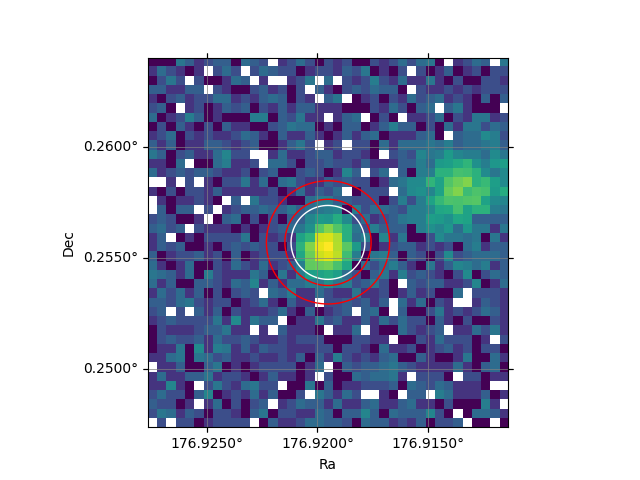

In [126]:
plot_map(transient, gmap_res, **{k: config_gaper[k] for k in ["ra", "dec", "radius", "annulus"]})

In [125]:
%%time
photon_events = run_gAperture(**config_gaper)

Using v1.28.9 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [176.919525856024, 0.255696872807351]
 tranges: [[762275988.995, 762276104.995], [765579107.995, 765579821.995], [765585336.995, 765585739.995], [766525332.995, 766526576.995], [858613178.995, 858613287.995], [919754986.995, 919755917.995]]
 radius:  0.0016666666666666666
 annulus: [0.0019444444444444444, 0.002777777777777778]
 stepsz:  60.0
 csvfile: ./out/test_gAperture_lc.csv
 verbose: 3
CPU times: user 36.8 s, sys: 2.88 s, total: 39.7 s          76.919525856024, 0.255696872807351]                                                            
Wall time: 5min 37s


In [13]:
%%time
photon_events = gp.gAperture(**config_gaper)

Using v1.28.9 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [242.368075, 53.673492]
 tranges: [[768413479.995, 768413580.995], [772224465.995, 772225688.995], [773123944.995, 773124202.995], [775283436.995, 775285077.995], [799089890.995, 799091497.995], [799291058.995, 799292175.995], [799296943.995, 799297509.995], [799308776.995, 799309652.995], [799415698.995, 799415804.995], [802332505.995, 802333573.995], [802374181.995, 802374993.995], [802450944.995, 802451924.995], [806060123.995, 806061578.995], [806071998.995, 806073379.995], [806083791.995, 806085240.995], [806108028.995, 806108889.995], [806409264.995, 806410592.995], [806509887.995, 806511165.995], [806527677.995, 806528914.995], [806616440.995, 806617663.995], [806628399.995, 806629496.995], [806634339.995, 806635351.995], [806699140.995, 806700501.995], [806758375.995, 806759678.995], [836916198.995, 836917810.995], [836928036.995, 836929640.995], [837289132.995, 837290458.

/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1000: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_err_1'] = (lcurve['mag'] -
/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1003: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_err_2'] = (gxt.counts2mag(lcurve['cps'] -
/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1007: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_bgsub_err_1'] = (lcurve['mag_bgsub'] -
/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1010: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_bgsub_err_2'] = (gxt.counts2mag(lcurve['cps_bgsub'] -


CPU times: user 6min 51s, sys: 29.6 s, total: 7min 21s                                                                  
Wall time: 1h 29min 5s


In [14]:
lc_data = read_lc(config_gaper["csvfile"])
sel = lc_data["t_mean"] > 1

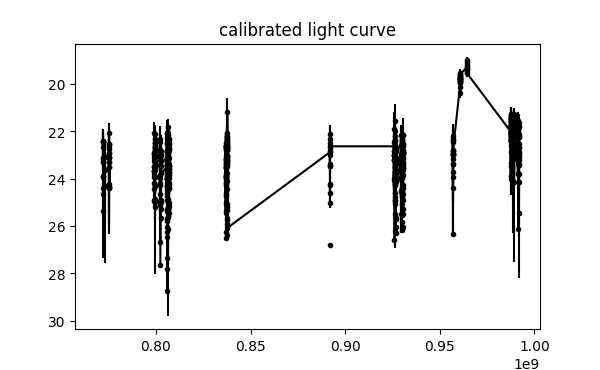

In [17]:
fig2, ax2 = vutils.nb_fig(num=f"{transient}_lc", gr_size=6)
ax2.errorbar(
    lc_data[sel]["t_mean"],
    lc_data[sel]["mag_bgsub"],
    yerr=[lc_data[sel]["mag_bgsub_err_1"], lc_data[sel]["mag_bgsub_err_2"]],
    color="k",
    marker="o",
    ms=3,
)
ax2.set_title("calibrated light curve")
ax2.invert_yaxis()

In [109]:
photon_events

NameError: name 'photon_events' is not defined